<a href="https://colab.research.google.com/github/jhyoo78/jhyoo78/blob/main/gan_1_step_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cat /proc/meminfo       # !는 Jupyter의  내부 shell command 를 실행할 때 사용함

In [ ]:
!nvidia-smi   #  ! 는 jupyter  내부 shell 명령을 실행할 때 사용

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
x=3.5
y=x*x+2
print(x,y)

3.5 14.25


In [ ]:
import torch
x=torch.tensor(3.5)
print(x)
y=x+3
print(y)

tensor(3.5000)
tensor(6.5000)


In [ ]:
import torch
x=torch.tensor(3.5, requires_grad=True)  # requires_grad=True 는 x에 대한 기울기 계산을 하도록 설정한 것임.
y=(x-1) * (x-2) * (x-3)       # Pytorch를 사용하면 y가 x로부터 생성된 것을 기억한다.
print("y=", y)
y.backward()    #  함수 y를 미분하여 그 결과(기울기 값의 list)를 tensor x에 저장해둔다.
x.grad          #  그 중에서 x 값==3.5에 해당하는 기울기 값을 출력한다.

y= tensor(1.8750, grad_fn=<MulBackward0>)


tensor(5.7500)

In [ ]:
# mount Drive to access data files
from google.colab import drive
drive.mount('./mount')    # 실행하면 '노트북에서 Google Drive 파일에 액세스하도록 허용하시겠습니까?' 라는 질문이 나온다. 동의하면 됨
# 위 명령에 동의하고 완료되면 Mounted at ./mount 가 출력됨.

Mounted at ./mount


In [ ]:
# import pandas to read csv files
import pandas

# import matplotlib to show images
import matplotlib.pyplot as plt

#import CSV file
df = pandas.read_csv('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv', header=None)  # 구글 드라이브에 미리 폴더를 만들고 파일을 다운 받아두었음.
df.head()   # 처음 5개 행을 출력한다.

# 각 행의 첫 수자는 이미지의 숫자이며, 나머지 784 = 28 x 28 pixel의 갑이다.

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 데이터 프레임의 구조 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


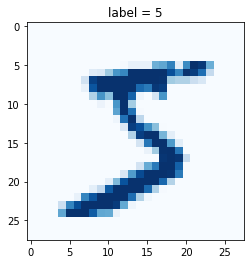

In [ ]:
# get data from dataframe
row =0
data = df.iloc[row]   # interger location(행,열의 index)으로 df 읽기, loc은 이 밖에 행과 열의 이름으로 df를 읽을 때 사용

# label is the first value
label = data[0]

# image data is the remaining 784 values
img = data[1:].values.reshape(28,28)

plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='Blues')  # 출력 방법 지정
plt.show()                                           # 출력 명령

In [ ]:
# 소스코드 참고-->  https://github.com/makeyourownneuralnetwork/gan/blob/master/03_mnist_classifier.ipynb

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas
import matplotlib.pyplot as plt

In [ ]:
# mount Drive to access data files
from google.colab import drive
drive.mount('./mount')    # 실행하면 '노트북에서 Google Drive 파일에 액세스하도록 허용하시겠습니까?' 라는 질문이 나온다. 동의하면 됨
# 위 명령에 동의하고 완료되면 Mounted at ./mount 가 출력됨.

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [ ]:
# dataset class

class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass

    def __len__(self):             # 데이터셋의 크기를 반환
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]  # 데이터셋 중 n째(index로 지정함) 아이템으로부터 label을 추출하여 저장
        target = torch.zeros((10))          # 출력을 담을 텐서를 targer이라는 이름으로 생성하고 0으로 초기화 --> [0, 0, . . . 0]
        target[label] = 1.0                 #  텐서를 one-hot encoding으로 변환 --> 예: 정답이 4이면 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

        # image data, normalised from 0-255 to 0-1, 0~255의 이미지를 0~1로 정규화함
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

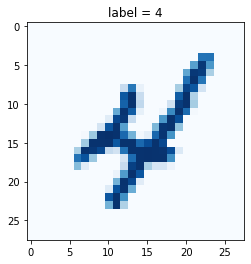

In [ ]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

# 데이터가 이미지인지 검사해본다.
mnist_dataset.plot_image(9)

In [ ]:

class Classifier(nn.Module):
    def __init__(self):        # 생성자_객체 초기화
        super().__init__()     # 생성자로 부모 클래스 생성자를 사용하기로 한다.

         # 신경망 계층 정의
        self.model=nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),          # 활성화 함수
            nn.Linear(200, 10),
            nn.Sigmoid()
        )
        # 손실함수
        self.loss_function = nn.MSELoss()

        # 단순한 Optimiser 설정: Stochastic Gradient Descendent
        self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass

    # 파이토치는 네트워크에 입력 데이터를 전달할 때 forward() 함수를 사용함
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)


    # 훈련을 수핼할 코드 작성
    def train(self, inputs, targets):
        # calculate the output of the network, 입력 값을 신경망에 입력하여 결과를 얻음
        outputs = self.forward(inputs)

        # 손실을 계산한다
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()   # 기울기를 0으로 초기화
        loss.backward()              # 손실의 기울기 계산
        self.optimiser.step()        # 기울기(경사)를 따라 가면서 파라미터들을 갱신

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

    pass

training epoch 1 of 1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
CPU times: user 1min 22s, sys: 876 ms, total: 1min 23s
Wall time: 1min 24s


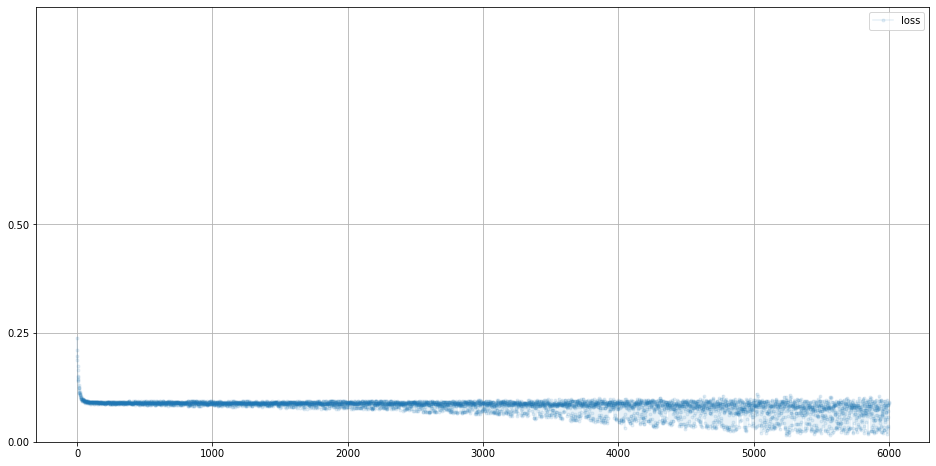

In [ ]:
%%time
          # Python 3 명령어로, %%time 은 cell 내의 모든 라인에 대한 wall time과 cpu time을 출력하고, %time은 첫라인의 소요 시간을 출력한다.
          # %timeit 은 한 라인을 반복 실행하여 더 정확한 실행 시간을 측정한다
          # CPU time 은 CPU 가 실행하는데 걸린 시간을 측정한 것으로, kernel time(file I/O) 등을 포함한다.
          # Wall clock time은 코드를 실행하는 데에 걸린 시간으로, 컴퓨터가 해당 실행 시점에 다른 작업을 하고 있다면 영향을 받을 수 있다.

# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)

    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

C.plot_progress()

(10000, 3)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


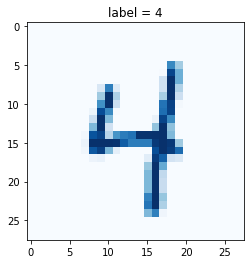

In [ ]:
# 훈련된 모델을 시험용 데이터셋에 적용하기

mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_test.csv')   # test용 데이터셋을 가져온다.

# 확인을 위해 index가 19인 데이터를 살펴 보자
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

import numpy as np

dim = np.shape(mnist_test_dataset)
print(dim)
print(mnist_test_dataset[9999][2])

tensor([0.0539, 0.0587, 0.1098, 0.1211, 0.2383, 0.0924, 0.1418, 0.2009, 0.0945,
        0.1962], grad_fn=<SigmoidBackward0>)


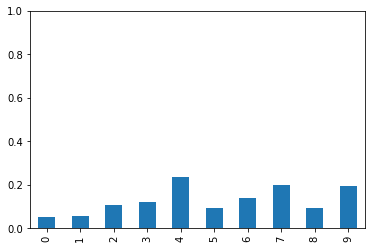

In [ ]:
image_data = mnist_test_dataset[record][1]   # [record][0], [record][2]로 변경해 볼 것

# query from trained network, 이미지 데이터를 훈련된 신경망(인스턴스)에 전달
output = C.forward(image_data)
print(output)                 # --->  신경망의 출력 label 값들...

# plot output tensor, detach()는 torch.tensor를 np.ndarry로 변환할 때 numpy는 pytorch와는 달리 계산 그래프(gradient)를 저장하지 않으므로 이를 없애준다.
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))


In [ ]:
# 구현한 분류기의 성능(정확도) 검사 ---> score = 10,000개의 데이터셋에 대해 정확하게 분류한 횟수

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1

    pass

print(score, items, score/items)

5853 10000 0.5853
